In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
path = '/content/gdrive/My Drive/Colab Notebooks/Thesis/'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
import re, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.utils import shuffle
%matplotlib inline

# Data Import

In [4]:
# Take the case of data in 2012
data_ori = pd.read_csv(path+'data2012.csv')
data_ori = data_ori.drop('fid',axis=1)
data = data_ori.copy()

In [5]:
data.head()

,country,fua_name,road_len,area,population,city_pop,cen_dist,night,land_cover,X,Y,city_id
0,PT,Lisboa,0.000000,669832.232177,0.0,2815535,38.606784,1.0300,11,-9.505698,38.784757,21
1,PT,Lisboa,0.000000,669755.214578,0.0,2815535,37.800579,0.7550,11,-9.497365,38.793090,21
2,PT,Lisboa,1.027019,669832.232177,0.0,2815535,37.685759,2.2275,11,-9.497365,38.784757,21
3,PT,Lisboa,0.083511,669909.235391,0.0,2815535,37.592849,2.1775,11,-9.497365,38.776424,21
4,PT,Lisboa,0.000000,669986.224222,0.0,2815535,37.522009,0.7500,11,-9.497365,38.768090,21


In [6]:
data.describe()

,road_len,area,population,city_pop,cen_dist,night,land_cover,X,Y,city_id
count,260534.000000,260534.000000,260534.000000,2.605340e+05,260534.000000,260534.000000,260534.000000,260534.000000,260534.000000,260534.000000
mean,2.618643,553544.642024,573.218713,4.394432e+06,48.840822,4.625352,6.632543,9.948661,49.823713,11.373537
std,3.395864,56618.677496,2237.603599,3.148661e+06,26.506507,12.620485,2.135577,8.835994,5.054657,5.586927
min,0.000000,428350.687197,0.000000,1.207469e+06,0.088187,0.000000,1.000000,-9.505698,38.409757,1.000000
25%,0.079500,522396.564847,0.000000,2.120416e+06,29.361106,0.347500,7.000000,2.452635,47.718090,7.000000
50%,1.553339,545090.648482,10.003517,2.939714e+06,44.830977,0.712500,7.000000,12.369302,50.759757,12.000000
75%,3.376450,579327.075616,125.796494,4.814757e+06,63.796209,2.750000,8.000000,16.669302,52.701424,17.000000
max,40.156530,673283.116298,58890.018027,1.166596e+07,166.826791,1361.780000,11.000000,26.460969,60.259757,22.000000


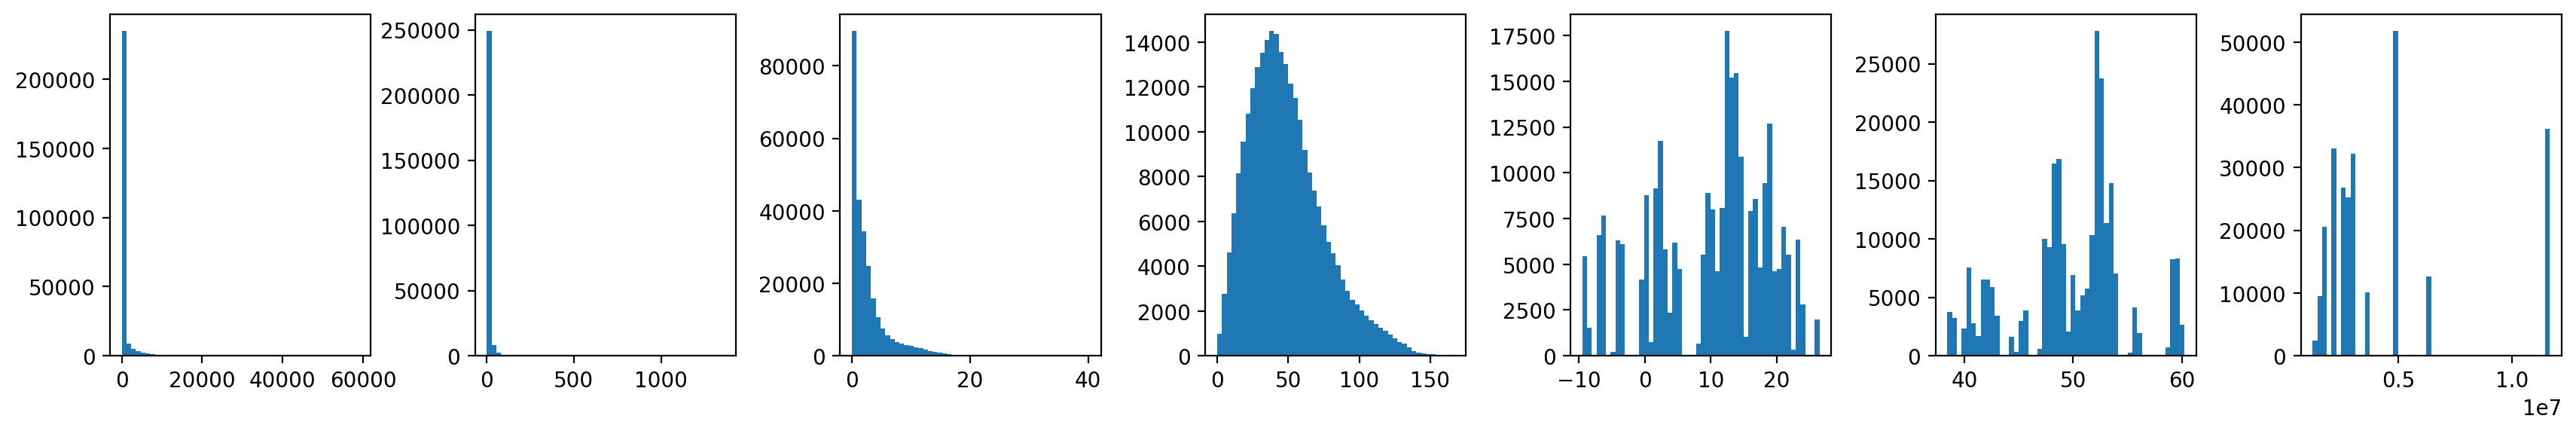

In [7]:
figs, axes = plt.subplots(nrows=1, ncols=7, figsize=(21,3), dpi=200)
alist = ['population','night','road_len','cen_dist','X','Y','city_pop']
for i in range(0,7):
    axes[i].hist(x=data[alist[i]], bins=50)
    plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show()

In [8]:
pop_min = 0.001

In [9]:
data['population_cat'] = data['population'] > pop_min

In [10]:
data.to_csv(path+'/data1.csv',index=False)
print('Step I: File Exported For Classification!')

Step I: File Exported For Classification!


In [ ]:
data_shuf = shuffle(data)
data_shuf.to_csv(path+'/data1_sf.csv',index=False)
print('Step I: File Shufflled Exported For Classification!')

Step I: File Shufflled Exported For Classification!


## Standardization

In [ ]:
# Based on city_id, to normalize the longitude and latitude
blist = ['X','Y']
for name in blist:
    data[name+'_max'] = data.groupby(['city_id'])[name].transform(max)
    data[name+'_min'] = data.groupby(['city_id'])[name].transform(min)
    data[name] = ((data[name] - data[name+'_min']) / (data[name+'_max'] - data[name+'_min']))

In [11]:
data = data[data['population_cat'] == 1]
data.describe()

,road_len,area,population,city_pop,cen_dist,night,land_cover,X,Y,city_id
count,191494.000000,191494.000000,191494.000000,1.914940e+05,191494.000000,191494.000000,191494.000000,191494.000000,191494.000000,191494.000000
mean,3.370854,555565.630196,779.883255,4.667142e+06,45.523277,5.957589,6.179405,9.044072,49.659390,11.717850
std,3.640940,54255.082130,2578.923904,3.429275e+06,25.451622,14.120320,2.200132,8.924055,4.864987,5.604289
min,0.000000,429000.466227,0.001002,1.207469e+06,0.088187,0.015000,1.000000,-9.489031,38.426424,1.000000
25%,1.085069,523975.212500,5.468659,2.626049e+06,26.635269,0.462500,7.000000,2.010969,47.918090,7.000000
50%,2.249753,550639.835260,38.046759,2.939714e+06,41.554841,1.122500,7.000000,11.394302,50.276424,12.000000
75%,4.335138,577126.675794,288.977651,4.892537e+06,59.946632,4.550000,7.000000,16.094302,52.568090,17.000000
max,40.156530,673130.363930,58890.018027,1.166596e+07,157.290051,1361.780000,11.000000,26.427635,60.209757,22.000000


<Figure size 800x600 with 0 Axes>

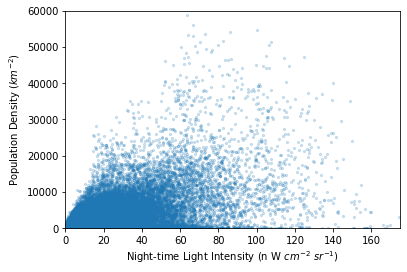

In [57]:
plt.figure(figsize=(4,3),dpi=200)
data.plot(kind='scatter', x='night', y='population', alpha=0.2, marker='.')
plt.xlim(0,175)
plt.ylim(0,6e4)
plt.xlabel('Night-time Light Intensity (n W $cm^{-2}$ $sr^{-1}$)')
plt.ylabel('Population Density ($km^{-2}$)')
plt.show()

In [ ]:
data_new = pd.DataFrame()

In [ ]:
blist = ['city_id','land_cover','area']
for name in blist:
    data_new[name] = data[name]

In [ ]:
# MinMaxScaler
scaler = preprocessing.MinMaxScaler()
blist = ['city_pop',]
for name in blist:
    data_new[name] = scaler.fit_transform(data[name].values.reshape(-1, 1))

In [ ]:
box_cox, mean, std = {}, {}, {}

In [ ]:
# Box-Cox
blist = ['population', 'night', 'cen_dist', 'road_len']
data['road_len'] = 0.000001 + data['road_len']
for name in blist:
    data[name], box_cox[name] = stats.boxcox(data[name])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# StandardScaler
scaler = preprocessing.StandardScaler()
blist = ['population','night','cen_dist','road_len','X','Y']
for name in blist:
    mean[name], std[name] = data[name].mean(), data[name].std()
    data_new[name] = scaler.fit_transform(data[name].values.reshape(-1, 1))

In [ ]:
box_cox, mean, std

({'cen_dist': 0.4544457663131222,
  'night': -0.22553801556625228,
  'population': 0.02837279324792106,
  'road_len': 0.2948282226915623},
 {'X': 0.48962825046566666,
  'Y': 0.4984488592873198,
  'cen_dist': 9.762960323420865,
  'night': 0.2197375900273375,
  'population': 3.9487919852473183,
  'road_len': 0.7171207244705375},
 {'X': 0.22244316071968143,
  'Y': 0.21778393142042998,
  'cen_dist': 3.2444866504064005,
  'night': 1.3003199440371558,
  'population': 3.2221005079579674,
  'road_len': 1.8754672371416614})

In [ ]:
data_new.head()

,city_id,land_cover,area,city_pop,population,night,cen_dist,road_len,X,Y
6,21,11,669678.182599,0.153757,-1.807728,0.234360,-0.186612,-2.160101,-2.127447,-0.151997
8,21,9,669832.232177,0.153757,-1.311403,0.387246,-0.197702,-0.314483,-2.127447,-0.242922
9,21,9,669909.235391,0.153757,-0.611365,0.583838,-0.201814,-1.242348,-2.127447,-0.288384
10,21,9,669986.224222,0.153757,-0.268417,0.165254,-0.204953,-0.195243,-2.127447,-0.333847
11,21,11,670063.198668,0.153757,-1.299249,-0.291615,-0.207110,-2.160101,-2.127447,-0.379309


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67ce1b9450>,
      dtype=object)

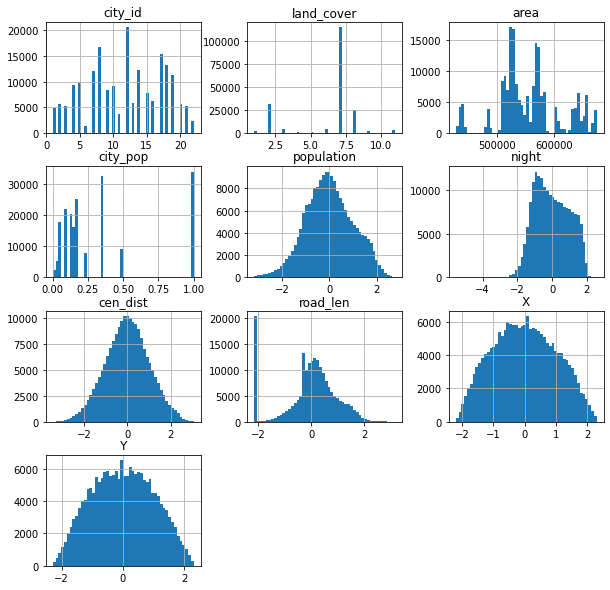

In [ ]:
data_new.hist(bins=50,figsize=(10,10))

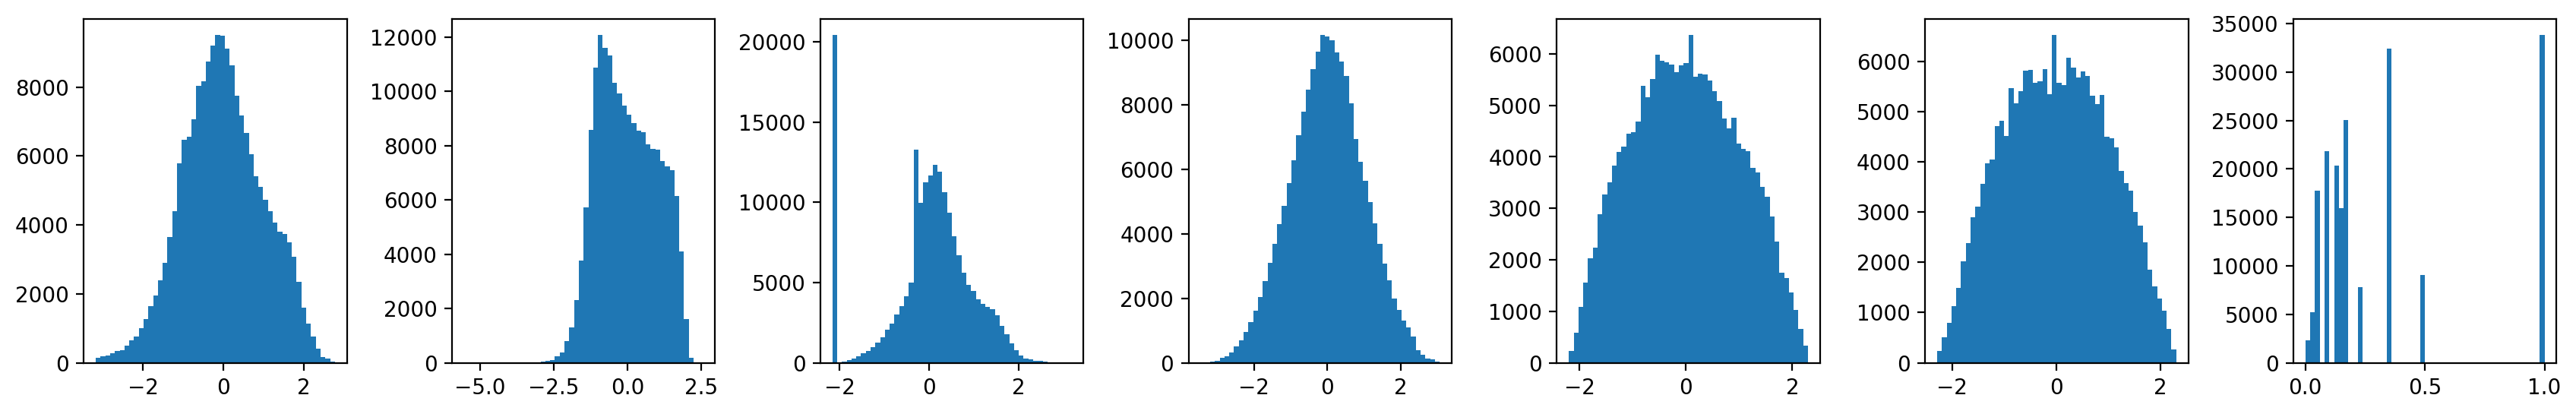

In [ ]:
figs, axes = plt.subplots(nrows=1, ncols=7, figsize=(21,3), dpi=200)
alist = ['population','night','road_len','cen_dist','X','Y','city_pop']
for i in range(0,7):
    axes[i].hist(x=data_new[alist[i]], bins=50)
    plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67cca16150>,
      dtype=object)

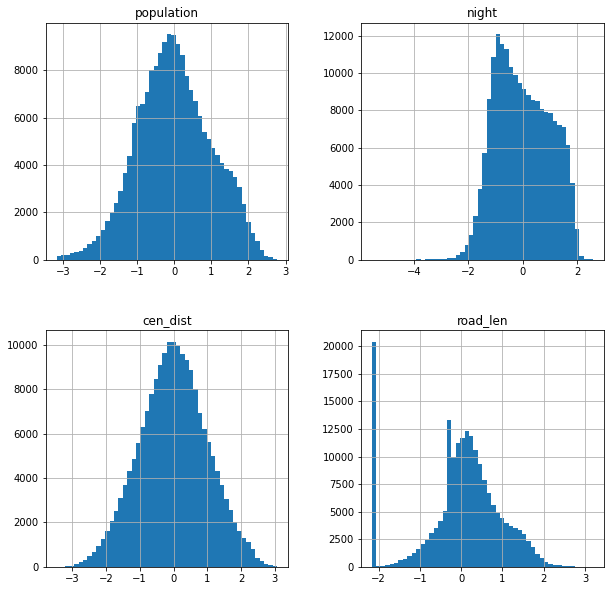

In [ ]:
data_sample = data_new[['population','night','cen_dist','road_len']]
data_sample.hist(bins=50,figsize=(10,10))

In [ ]:
data_new.to_csv(path+'/data2.csv',index=False)
print('Step II: File Exported For Regression!')

Step II: File Exported For Regression!


In [ ]:
data_shuf = shuffle(data_new)
data_shuf.to_csv(path+'/data2_sf.csv',index=False)
print('Step III: File Shufflled Exported For Regression!')

Step III: File Shufflled Exported For Regression!
